In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datafoobars import drop_personal_data, drop_goalkeeper_data, drop_categorical_data

In [43]:
fifa17_raw_data = pd.read_csv("data/FIFA17_official_data.csv")
fifa18_raw_data = pd.read_csv("data/FIFA18_official_data.csv")
fifa19_raw_data = pd.read_csv("data/FIFA19_official_data.csv")
fifa20_raw_data = pd.read_csv("data/FIFA20_official_data.csv")
fifa21_raw_data = pd.read_csv("data/FIFA21_official_data.csv")

old_raw_data = pd.concat([fifa17_raw_data, fifa18_raw_data, fifa19_raw_data, fifa20_raw_data, fifa21_raw_data], ignore_index=True)
old_raw_data.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness
0,176580,L. Suárez,29,https://cdn.sofifa.com/players/176/580/17_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,92,92,FC Barcelona,https://cdn.sofifa.com/teams/241/light_30.png,...,38.0,27.0,25.0,31.0,33.0,37.0,ST,88.0,NaN,NaN
1,178518,R. Nainggolan,28,https://cdn.sofifa.com/players/178/518/17_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,86,86,Roma,https://cdn.sofifa.com/teams/52/light_30.png,...,88.0,11.0,11.0,14.0,8.0,11.0,CDM,84.0,NaN,NaN
2,181872,A. Vidal,29,https://cdn.sofifa.com/players/181/872/17_60.png,Chile,https://cdn.sofifa.com/flags/cl.png,87,87,FC Bayern München,https://cdn.sofifa.com/teams/21/light_30.png,...,84.0,4.0,2.0,4.0,2.0,4.0,CDM,85.0,NaN,NaN
3,197445,D. Alaba,24,https://cdn.sofifa.com/players/197/445/17_60.png,Austria,https://cdn.sofifa.com/flags/at.png,86,89,FC Bayern München,https://cdn.sofifa.com/teams/21/light_30.png,...,83.0,5.0,7.0,14.0,15.0,9.0,LB,84.0,NaN,NaN
4,195864,P. Pogba,23,https://cdn.sofifa.com/players/195/864/17_60.png,France,https://cdn.sofifa.com/flags/fr.png,88,94,Manchester United,https://cdn.sofifa.com/teams/11/light_30.png,...,73.0,5.0,6.0,2.0,4.0,3.0,CAM,85.0,NaN,NaN


In [44]:
old_raw_data["Position"] = old_raw_data["Position"].str.extract(r'>\s*([^<]+)')

old_raw_data = old_raw_data.drop(old_raw_data[old_raw_data["Position"] == "SUB"].index)
old_raw_data = old_raw_data.drop(old_raw_data[old_raw_data["Position"] == "RES"].index)

old_raw_data = drop_personal_data(old_raw_data)
old_raw_data = drop_goalkeeper_data(old_raw_data)
old_raw_data = drop_categorical_data(old_raw_data, dropposition=False)
old_raw_data.drop("Overall", axis=1, inplace=True)

old_raw_data.dropna(inplace=True)
old_raw_data.shape

      Position  Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  \
0           ST      77.0       94.0             77.0          83.0     88.0   
1           LF      73.0       76.0             59.0          84.0     75.0   
2          LDM      76.0       77.0             81.0          84.0     78.0   
3           LB      82.0       63.0             75.0          83.0     68.0   
4          LDM      78.0       71.0             73.0          85.0     84.0   
...        ...       ...        ...              ...           ...      ...   
86650      RCB      23.0       27.0             83.0          43.0      NaN   
86706      NaN      36.0       55.0             47.0          51.0      NaN   
87039      NaN      15.0       20.0             15.0          23.0     17.0   
87371      NaN      13.0        9.0             10.0          24.0      6.0   
87378      NaN      12.0        5.0             10.0          20.0      6.0   

       Dribbling  Curve  FKAccuracy  LongPassing  .

(31115, 29)

In [45]:
position_mapping = {
    'Defender': ['LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB', 'CB'],
    'Midfielder': ['CAM', 'CDM', 'CM', 'LAM', 'LCM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM'],
    'Striker': ['CF', 'LF', 'LS', 'RF', 'RS', 'ST', 'RW', 'LW']
}

old_raw_data["Position"] = old_raw_data["Position"].map(
    {pos: category for category, positions in position_mapping.items() for pos in positions})

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = old_raw_data.drop("Position", axis=1)
y = old_raw_data["Position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [48]:
y_pred = rfc.predict(X_test)

rfc_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {rfc_accuracy: .2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy:  0.88
Classification report:
              precision    recall  f1-score   support

    Defender       0.92      0.95      0.93      2430
  Midfielder       0.85      0.88      0.86      2628
     Striker       0.87      0.75      0.81      1165

    accuracy                           0.88      6223
   macro avg       0.88      0.86      0.87      6223
weighted avg       0.88      0.88      0.88      6223


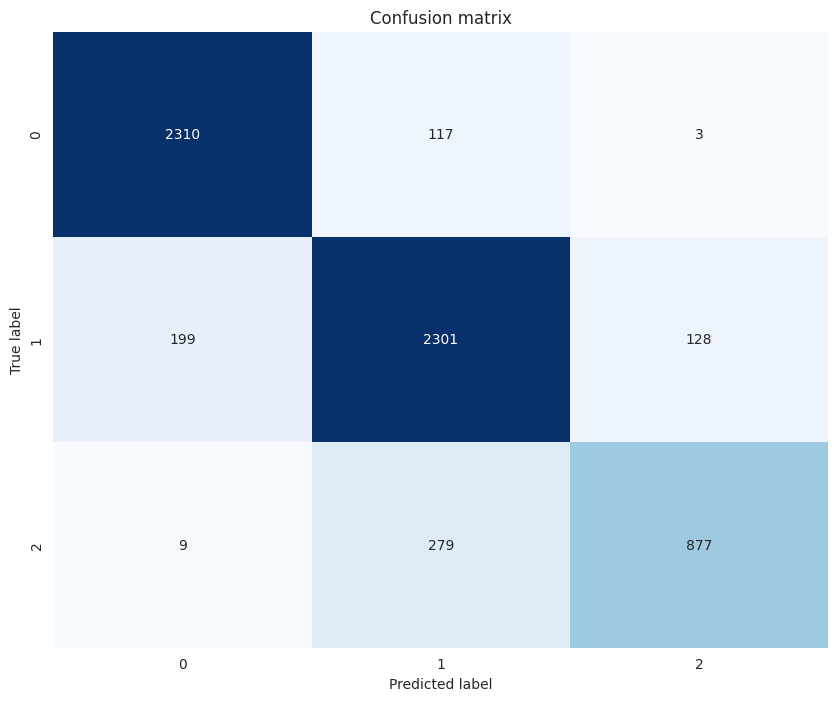

In [49]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show();